In [1]:
from __future__ import absolute_import, division, \
    print_function, unicode_literals

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [4]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [5]:
type(dataset)

dict

In [6]:
dataset.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [7]:
train_dataset

<_OptionsDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>

In [8]:
encoder = info.features['text'].encoder

In [9]:
encoder

<SubwordTextEncoder vocab_size=8185>

In [10]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [11]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [12]:
assert original_string == sample_string

In [13]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [14]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [15]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)

In [16]:
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))

In [17]:
test_dataset = test_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_dataset))

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=2,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/2
391/391 [==============================] - 40s 103ms/step - loss: 0.2263 - accuracy: 0.9162 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/2
391/391 [==============================] - 40s 103ms/step - loss: 0.2000 - accuracy: 0.9294 - val_loss: 0.3197 - val_accuracy: 0.8719


In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 17s 43ms/step - loss: 0.3310 - accuracy: 0.8688
Test Loss: 0.3309913483041022
Test Accuracy: 0.8687999844551086


In [23]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [24]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [25]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.5997306]]


In [26]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.53000873]]


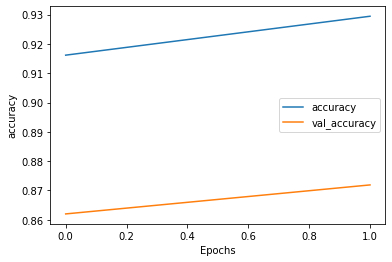

In [27]:
plot_graphs(history, 'accuracy')

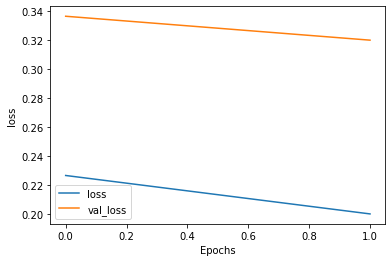

In [28]:
plot_graphs(history, 'loss')